In [1]:
# ============================================================================
# CELL 1: Import Libraries
# ============================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, 
                            cohen_kappa_score, balanced_accuracy_score,
                            roc_auc_score, roc_curve)
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, ResNet50V2, EfficientNetB0
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    print("GPU Name:", tf.config.list_physical_devices('GPU')[1].name)

print("✓ Libraries imported successfully!")

TensorFlow version: 2.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
GPU Name: /physical_device:GPU:1
✓ Libraries imported successfully!


In [2]:
# ============================================================================
# CELL 2: Configuration
# ============================================================================
# Paths
DATASET_PATH = r"C:\Users\anush\OneDrive\Desktop\dl project model\Diabetic Retenopathy.v8i.folder.new"
MODEL_SAVE_PATH = r"C:\Users\anush\Desktop\New folder\Models13"
RESULTS_PATH = r"C:\Users\anush\Desktop\New folder\Results"

# Create directories
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

# Training configuration
CONFIG = {
    'img_size': 224,
    'batch_size': 8,
    'num_epochs': 13,
    'learning_rate': 1e-4,
    'num_classes': 5,
    'early_stopping_patience': 5,
    'reduce_lr_patience': 5,
    
    # Class names (in alphabetical order for ImageDataGenerator)
    'class_names': ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe'],
    
    # Class weighting
    'use_class_weights': True,
    'use_focal_loss': True,  # Set True for focal loss
    'focal_alpha': 0.25,
    'focal_gamma': 2.0,
    
    # Data augmentation
    'use_augmentation': True,
    
    # Model architecture
    'encoder_name': 'resnet50',  # 'resnet50', 'efficientnetb0'
    'pretrained_encoder': True,
    'dropout_rate': 0.5,
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")




Configuration:
  img_size: 224
  batch_size: 8
  num_epochs: 13
  learning_rate: 0.0001
  num_classes: 5
  early_stopping_patience: 5
  reduce_lr_patience: 5
  class_names: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
  use_class_weights: True
  use_focal_loss: True
  focal_alpha: 0.25
  focal_gamma: 2.0
  use_augmentation: True
  encoder_name: resnet50
  pretrained_encoder: True
  dropout_rate: 0.5


In [ ]:
# ============================================================================
# CELL 3: Data Generators
# ============================================================================

def create_data_generators(config):
    """Create train, validation, and test data generators"""
    
    # Training data augmentation
    if config['use_augmentation']:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1,
            brightness_range=[0.8, 1.2],
            fill_mode='constant',
            cval=0
        )
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)
    
    # Validation and test data (no augmentation)
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    train_generator = train_datagen.flow_from_directory(
        os.path.join(DATASET_PATH, 'train'),
        target_size=(config['img_size'], config['img_size']),
        batch_size=config['batch_size'],
        class_mode='categorical',
        shuffle=True,
        seed=42
    )
    
    val_generator = val_test_datagen.flow_from_directory(
        os.path.join(DATASET_PATH, 'validation'),
        target_size=(config['img_size'], config['img_size']),
        batch_size=config['batch_size'],
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(DATASET_PATH, 'test'),
        target_size=(config['img_size'], config['img_size']),
        batch_size=config['batch_size'],8
        class_mode='categorical',
        shuffle=False
    )
    
    print("\n📊 Data Generators Created:")
    print(f"  Training samples: {train_generator.samples}")
    print(f"  Validation samples: {val_generator.samples}")
    print(f"  Test samples: {test_generator.samples}")
    print(f"\n  Class indices: {train_generator.class_indices}")
    
    return train_generator, val_generator, test_generator


def compute_class_weights_from_generator(generator, num_classes):
    """Compute class weights from data generator"""
    
    # Get all labels
    labels = generator.classes
    
    # Compute class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(labels),
        y=labels
    )
    
    # Create class weight dictionary
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    print("\n⚖️  Class Weights:")
    for idx, (class_name, weight) in enumerate(zip(sorted(generator.class_indices.keys()), class_weights)):
        print(f"  {class_name:<20}: {weight:.4f}")
    
    return class_weight_dict, class_weights


In [4]:
# ============================================================================
# CELL 4: Attention Mechanisms
# ============================================================================

def attention_gate(gating, skip_connection, inter_channels, name):
    """
    Attention Gate mechanism
    
    Args:
        gating: Gating signal from decoder (coarser scale)
        skip_connection: Skip connection from encoder (finer scale)
        inter_channels: Number of intermediate channels
        name: Name prefix for layers
    """
    # Gating path
    g = layers.Conv2D(inter_channels, 1, strides=1, padding='same', 
                     name=f'{name}_g_conv')(gating)
    g = layers.BatchNormalization(name=f'{name}_g_bn')(g)
    
    # Skip connection path
    x = layers.Conv2D(inter_channels, 1, strides=1, padding='same',
                     name=f'{name}_x_conv')(skip_connection)
    x = layers.BatchNormalization(name=f'{name}_x_bn')(x)
    
    # Attention coefficients
    psi = layers.Add(name=f'{name}_add')([g, x])
    psi = layers.Activation('relu', name=f'{name}_relu')(psi)
    psi = layers.Conv2D(1, 1, strides=1, padding='same', 
                       name=f'{name}_psi_conv')(psi)
    psi = layers.BatchNormalization(name=f'{name}_psi_bn')(psi)
    psi = layers.Activation('sigmoid', name=f'{name}_sigmoid')(psi)
    
    # Apply attention
    output = layers.Multiply(name=f'{name}_multiply')([skip_connection, psi])
    
    return output


def cbam_block(input_tensor, reduction=16, name='cbam'):
    """
    Convolutional Block Attention Module (CBAM)
    
    Args:
        input_tensor: Input tensor
        reduction: Reduction ratio for channel attention
        name: Name prefix for layers
    """
    channels = input_tensor.shape[-1]
    
    # Channel Attention
    avg_pool = layers.GlobalAveragePooling2D(name=f'{name}_avg_pool')(input_tensor)
    max_pool = layers.GlobalMaxPooling2D(name=f'{name}_max_pool')(input_tensor)
    
    # Shared MLP
    dense1 = layers.Dense(channels // reduction, activation='relu', name=f'{name}_dense1')
    dense2 = layers.Dense(channels, name=f'{name}_dense2')
    
    avg_out = dense2(dense1(avg_pool))
    max_out = dense2(dense1(max_pool))
    
    channel_attention = layers.Add(name=f'{name}_channel_add')([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid', name=f'{name}_channel_sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, channels), name=f'{name}_channel_reshape')(channel_attention)
    
    x = layers.Multiply(name=f'{name}_channel_multiply')([input_tensor, channel_attention])
    
    # Spatial Attention
    avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True),
                                    name=f'{name}_spatial_avg')(x)
    max_pool_spatial = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True),
                                    name=f'{name}_spatial_max')(x)
    
    spatial_concat = layers.Concatenate(axis=-1, name=f'{name}_spatial_concat')([avg_pool_spatial, max_pool_spatial])
    spatial_attention = layers.Conv2D(1, 7, padding='same', activation='sigmoid',
                                     name=f'{name}_spatial_conv')(spatial_concat)
    
    output = layers.Multiply(name=f'{name}_spatial_multiply')([x, spatial_attention])
    
    return output


In [5]:
# ============================================================================
# CELL 5: Attention U-Net Model
# ============================================================================

def build_attention_unet(config):
    """
    Build Attention U-Net model for classification
    
    Args:
        config: Configuration dictionary
    
    Returns:
        Keras model
    """
    inputs = layers.Input(shape=(config['img_size'], config['img_size'], 3))
    
    # Load pretrained encoder
    if config['encoder_name'] == 'resnet50':
        base_model = ResNet50(weights='imagenet' if config['pretrained_encoder'] else None,
                             include_top=False, input_tensor=inputs)
        # Get encoder layers
        e1 = base_model.get_layer('conv1_relu').output  # 112x112x64
        e2 = base_model.get_layer('conv2_block3_out').output  # 56x56x256
        e3 = base_model.get_layer('conv3_block4_out').output  # 28x28x512
        e4 = base_model.get_layer('conv4_block6_out').output  # 14x14x1024
        e5 = base_model.get_layer('conv5_block3_out').output  # 7x7x2048
        
        channels = [64, 256, 512, 1024, 2048]
        
    elif config['encoder_name'] == 'efficientnetb0':
        base_model = EfficientNetB0(weights='imagenet' if config['pretrained_encoder'] else None,
                                   include_top=False, input_tensor=inputs)
        # Get encoder layers
        e1 = base_model.get_layer('block2a_expand_activation').output
        e2 = base_model.get_layer('block3a_expand_activation').output
        e3 = base_model.get_layer('block4a_expand_activation').output
        e4 = base_model.get_layer('block6a_expand_activation').output
        e5 = base_model.output
        
        channels = [e1.shape[-1], e2.shape[-1], e3.shape[-1], e4.shape[-1], e5.shape[-1]]
    
    else:
        raise ValueError(f"Unsupported encoder: {config['encoder_name']}")
    
    # Decoder with Attention Gates
    # Decoder block 5
    d5 = layers.UpSampling2D(size=(2, 2), name='upsample5')(e5)
    d5 = layers.Conv2D(channels[3], 3, padding='same', name='d5_conv1')(d5)
    d5 = layers.BatchNormalization(name='d5_bn1')(d5)
    d5 = layers.Activation('relu', name='d5_relu1')(d5)
    
    e4_att = attention_gate(d5, e4, channels[3]//2, name='att5')
    d5 = layers.Concatenate(name='concat5')([d5, e4_att])
    
    d5 = layers.Conv2D(channels[3], 3, padding='same', name='d5_conv2')(d5)
    d5 = layers.BatchNormalization(name='d5_bn2')(d5)
    d5 = layers.Activation('relu', name='d5_relu2')(d5)
    
    # Decoder block 4
    d4 = layers.UpSampling2D(size=(2, 2), name='upsample4')(d5)
    d4 = layers.Conv2D(channels[2], 3, padding='same', name='d4_conv1')(d4)
    d4 = layers.BatchNormalization(name='d4_bn1')(d4)
    d4 = layers.Activation('relu', name='d4_relu1')(d4)
    
    e3_att = attention_gate(d4, e3, channels[2]//2, name='att4')
    d4 = layers.Concatenate(name='concat4')([d4, e3_att])
    
    d4 = layers.Conv2D(channels[2], 3, padding='same', name='d4_conv2')(d4)
    d4 = layers.BatchNormalization(name='d4_bn2')(d4)
    d4 = layers.Activation('relu', name='d4_relu2')(d4)
    
    # Decoder block 3
    d3 = layers.UpSampling2D(size=(2, 2), name='upsample3')(d4)
    d3 = layers.Conv2D(channels[1], 3, padding='same', name='d3_conv1')(d3)
    d3 = layers.BatchNormalization(name='d3_bn1')(d3)
    d3 = layers.Activation('relu', name='d3_relu1')(d3)
    
    e2_att = attention_gate(d3, e2, channels[1]//2, name='att3')
    d3 = layers.Concatenate(name='concat3')([d3, e2_att])
    
    d3 = layers.Conv2D(channels[1], 3, padding='same', name='d3_conv2')(d3)
    d3 = layers.BatchNormalization(name='d3_bn2')(d3)
    d3 = layers.Activation('relu', name='d3_relu2')(d3)
    
    # Decoder block 2
    d2 = layers.UpSampling2D(size=(2, 2), name='upsample2')(d3)
    d2 = layers.Conv2D(channels[0], 3, padding='same', name='d2_conv1')(d2)
    d2 = layers.BatchNormalization(name='d2_bn1')(d2)
    d2 = layers.Activation('relu', name='d2_relu1')(d2)
    
    e1_att = attention_gate(d2, e1, channels[0]//2, name='att2')
    d2 = layers.Concatenate(name='concat2')([d2, e1_att])
    
    d2 = layers.Conv2D(channels[0], 3, padding='same', name='d2_conv2')(d2)
    d2 = layers.BatchNormalization(name='d2_bn2')(d2)
    d2 = layers.Activation('relu', name='d2_relu2')(d2)
    
    # Apply CBAM
    features = cbam_block(d2, reduction=16, name='cbam')
    
    # Global pooling and classification head
    gap = layers.GlobalAveragePooling2D(name='global_avg_pool')(features)
    
    # Classification head
    x = layers.Dropout(config['dropout_rate'], name='dropout1')(gap)
    x = layers.Dense(512, activation='relu', name='fc1')(x)
    x = layers.Dropout(config['dropout_rate'] * 0.6, name='dropout2')(x)
    outputs = layers.Dense(config['num_classes'], activation='softmax', name='predictions')(x)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs, name='AttentionUNet')
    
    return model

In [6]:
# ============================================================================
# CELL 6: Loss Functions
# ============================================================================
class FocalLoss(tf.keras.losses.Loss):
    """Focal Loss for handling class imbalance"""
    
    def __init__(self, alpha=0.25, gamma=2.0, class_weights=None, name='focal_loss'):
        super().__init__(name=name)
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights
    
    def call(self, y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        
        # Calculate cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Calculate focal loss
        focal_loss = self.alpha * tf.pow(1 - y_pred, self.gamma) * cross_entropy
        
        # Apply class weights if provided
        if self.class_weights is not None:
            weights = tf.reduce_sum(y_true * self.class_weights, axis=-1, keepdims=True)
            focal_loss = focal_loss * weights
        
        return tf.reduce_sum(focal_loss, axis=-1)


def get_loss_function(config, class_weights):
    """Get loss function based on configuration"""
    
    if config['use_focal_loss']:
        print("Using Focal Loss")
        loss = FocalLoss(
            alpha=config['focal_alpha'],
            gamma=config['focal_gamma'],
            class_weights=class_weights if config['use_class_weights'] else None
        )
    else:
        print("Using Categorical Cross Entropy with Class Weights")
        loss = 'categorical_crossentropy'
    
    return loss



In [7]:
# ============================================================================
# CELL 7: Custom Metrics
# ============================================================================

class BalancedAccuracy(tf.keras.metrics.Metric):
    """Balanced Accuracy metric for imbalanced datasets"""
    
    def __init__(self, num_classes, name='balanced_accuracy', **kwargs):
        super(BalancedAccuracy, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.confusion_matrix = self.add_weight(
            name='confusion_matrix',
            shape=(num_classes, num_classes),
            initializer='zeros'
        )
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        
        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes)
        self.confusion_matrix.assign_add(tf.cast(cm, tf.float32))
    
    def result(self):
        # Calculate per-class accuracy
        per_class_acc = tf.linalg.diag_part(self.confusion_matrix) / tf.reduce_sum(self.confusion_matrix, axis=1)
        # Handle division by zero
        per_class_acc = tf.where(tf.math.is_nan(per_class_acc), tf.zeros_like(per_class_acc), per_class_acc)
        return tf.reduce_mean(per_class_acc)
    
    def reset_state(self):
        self.confusion_matrix.assign(tf.zeros_like(self.confusion_matrix))



In [8]:
# ============================================================================
# CELL 8: Create and Compile Model
# ============================================================================

print("\n" + "="*70)
print("INITIALIZING MODEL")
print("="*70)

# Create data generators
train_gen, val_gen, test_gen = create_data_generators(CONFIG)

# Compute class weights
class_weight_dict, class_weights_array = compute_class_weights_from_generator(train_gen, CONFIG['num_classes'])

# Build model
print("\n🏗️  Building Attention U-Net model...")
model = build_attention_unet(CONFIG)

# Print model summary
print("\n📊 Model Summary:")
model.summary()

# Count parameters
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")

# Get loss function
loss_fn = get_loss_function(CONFIG, class_weights_array)

# Compile model
print("\n⚙️  Compiling model...")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
    loss=loss_fn if CONFIG['use_focal_loss'] else 'categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
        BalancedAccuracy(num_classes=CONFIG['num_classes'])
    ]
)

print("✓ Model compiled successfully!")



INITIALIZING MODEL
Found 29732 images belonging to 5 classes.
Found 1696 images belonging to 5 classes.
Found 2544 images belonging to 5 classes.

📊 Data Generators Created:
  Training samples: 29732
  Validation samples: 1696
  Test samples: 2544

  Class indices: {'Mild': 0, 'Moderate': 1, 'No_DR': 2, 'Proliferate_DR': 3, 'Severe': 4}

⚖️  Class Weights:
  Mild                : 4.9307
  Moderate            : 1.7998
  No_DR               : 0.9150
  Proliferate_DR      : 0.6073
  Severe              : 0.6658

🏗️  Building Attention U-Net model...

📊 Model Summary:
Model: "AttentionUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
         

In [9]:
# ============================================================================
# CELL 9: Callbacks
# ============================================================================

# Model checkpoint
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=os.path.join(MODEL_SAVE_PATH, 'best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Early stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=CONFIG['early_stopping_patience'],
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=CONFIG['reduce_lr_patience'],
    min_lr=1e-7,
    verbose=1
)

# TensorBoard
tensorboard_callback = callbacks.TensorBoard(
    log_dir=os.path.join(RESULTS_PATH, 'logs'),
    histogram_freq=1,
    write_graph=True
)

# CSV Logger
csv_logger = callbacks.CSVLogger(
    os.path.join(RESULTS_PATH, 'training_log.csv'),
    append=False
)

# Learning rate scheduler (optional)
def lr_schedule(epoch, lr):
    """Learning rate schedule"""
    if epoch > 0 and epoch % 15 == 0:
        return lr * 0.5
    return lr

lr_scheduler = callbacks.LearningRateScheduler(lr_schedule, verbose=0)

callback_list = [
    checkpoint_callback,
    early_stopping,
    reduce_lr,
    tensorboard_callback,
    csv_logger
]

print("\n✓ Callbacks configured:")
print("  - Model Checkpoint")
print("  - Early Stopping")
print("  - Reduce LR on Plateau")
print("  - TensorBoard")
print("  - CSV Logger")


✓ Callbacks configured:
  - Model Checkpoint
  - Early Stopping
  - Reduce LR on Plateau
  - TensorBoard
  - CSV Logger


In [10]:
# ============================================================================
# CELL 10: Train Model
# ============================================================================

print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

# Calculate steps
steps_per_epoch = train_gen.samples // CONFIG['batch_size']
validation_steps = val_gen.samples // CONFIG['batch_size']

print(f"\nSteps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Train model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=CONFIG['num_epochs'],
    validation_data=val_gen,
    validation_steps=validation_steps,
    class_weight=class_weight_dict if CONFIG['use_class_weights'] and not CONFIG['use_focal_loss'] else None,
    callbacks=callback_list,
    verbose=1
)

print("\n" + "="*70)
print("TRAINING COMPLETED")
print("="*70)


STARTING TRAINING

Steps per epoch: 3716
Validation steps: 212
Epoch 1/13
3716/3716 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.4999 - categorical_accuracy: 0.4999 - top_2_accuracy: 0.7948 - balanced_accuracy: 0.5058
Epoch 1: val_loss improved from inf to 0.12792, saving model to C:\Users\anush\Desktop\New folder\Models13\best_model.h5
3716/3716 [==============================] - 2248s 601ms/step - loss: 0.1476 - accuracy: 0.4999 - categorical_accuracy: 0.4999 - top_2_accuracy: 0.7948 - balanced_accuracy: 0.5058 - val_loss: 0.1279 - val_accuracy: 0.7229 - val_categorical_accuracy: 0.7229 - val_top_2_accuracy: 0.8738 - val_balanced_accuracy: 0.4938 - lr: 1.0000e-04
Epoch 2/13
3716/3716 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.5637 - categorical_accuracy: 0.5637 - top_2_accuracy: 0.8609 - balanced_accuracy: 0.5870
Epoch 2: val_loss improved from 0.12792 to 0.11859, saving model to C:\Users\anush\Desktop\New folder\Models13\best_

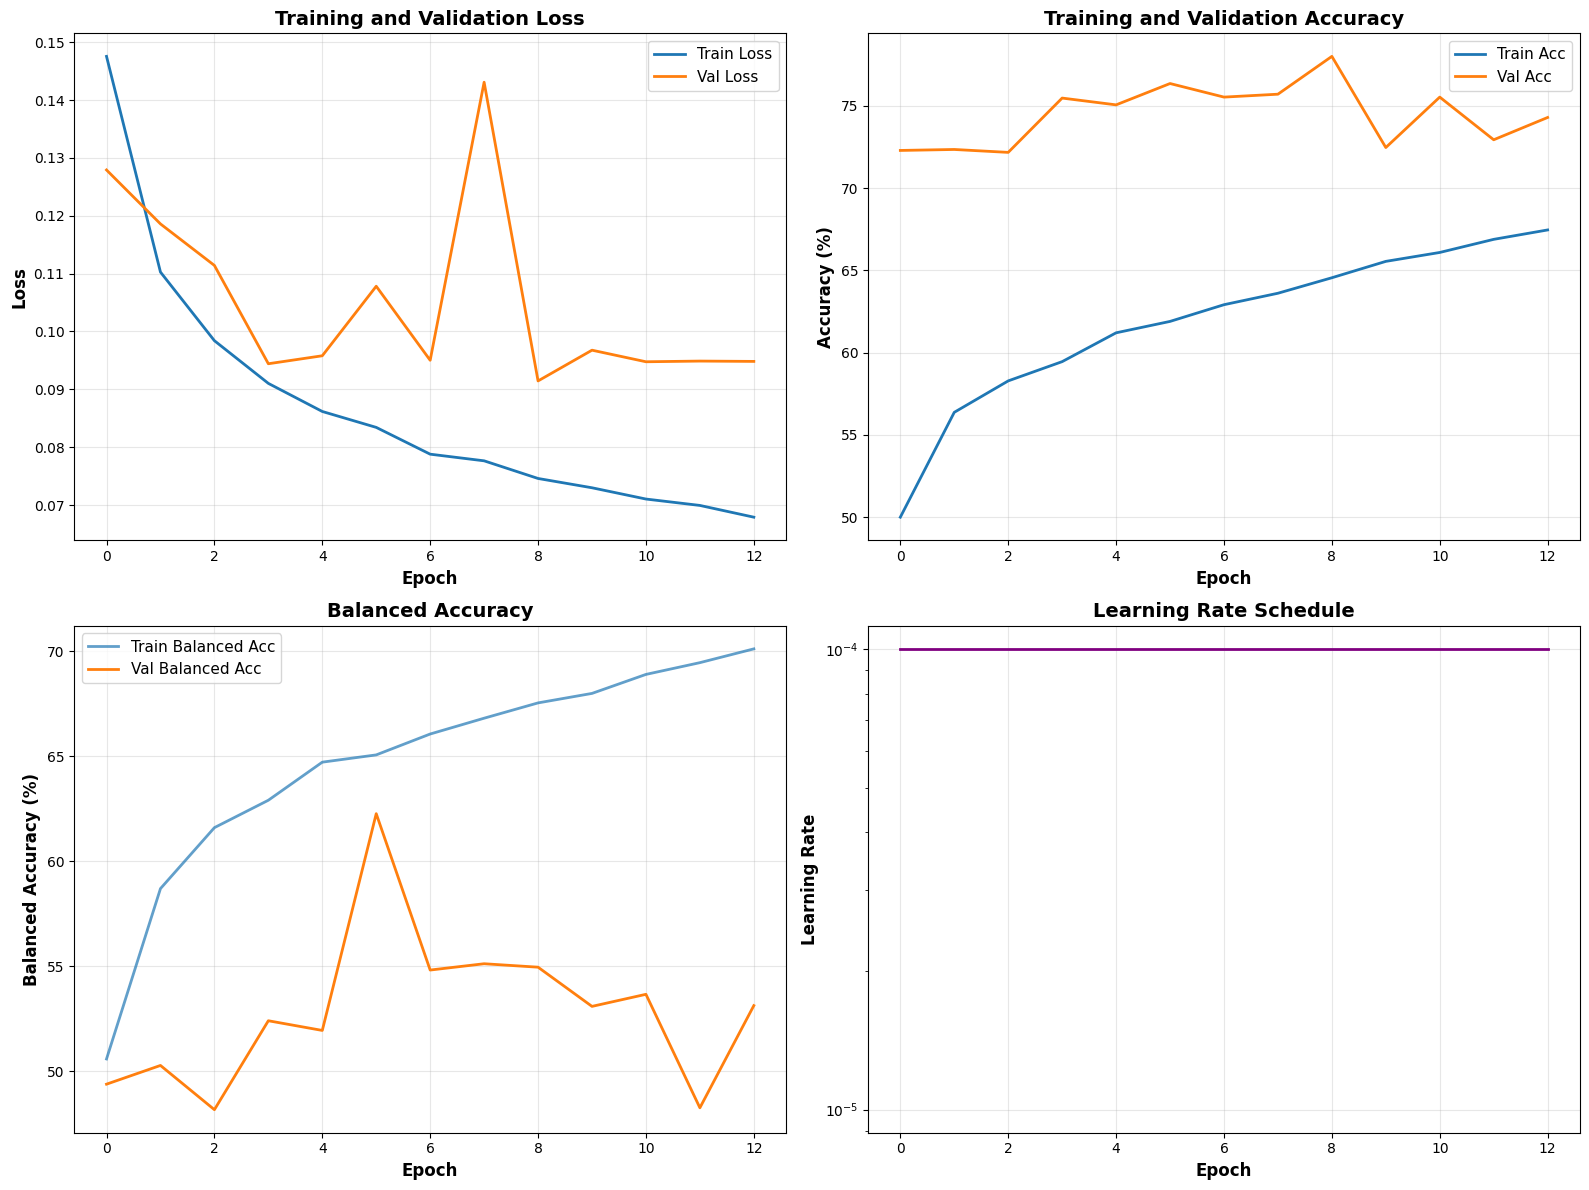

✓ Training history saved


In [17]:
# ============================================================================
# CELL 11: Plot Training History
# ============================================================================

def plot_training_history(history):
    """Plot training metrics"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Loss
    ax = axes[0, 0]
    ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    # Accuracy
    ax = axes[0, 1]
    ax.plot([x*100 for x in history.history['accuracy']], label='Train Acc', linewidth=2)
    ax.plot([x*100 for x in history.history['val_accuracy']], label='Val Acc', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    # Balanced Accuracy
    ax = axes[1, 0]
    if 'balanced_accuracy' in history.history:
        ax.plot([x*100 for x in history.history['balanced_accuracy']], 
               label='Train Balanced Acc', linewidth=2, alpha=0.7)
        ax.plot([x*100 for x in history.history['val_balanced_accuracy']], 
               label='Val Balanced Acc', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Balanced Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Balanced Accuracy', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    # Learning Rate
    ax = axes[1, 1]
    if 'lr' in history.history:
        ax.plot(history.history['lr'], linewidth=2, color='purple')
        ax.set_yscale('log')
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
    ax.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'training_history.png'), dpi=300)
    plt.show()
    
    print("✓ Training history saved")


plot_training_history(history)


📥 Loading best model...
⚠️  Error loading with custom objects: FocalLoss.__init__() got an unexpected keyword argument 'reduction'
Trying alternative method...
Using Focal Loss
✓ Model loaded and recompiled successfully

EVALUATING ON VALIDATION SET

Generating predictions...
212/212 [==============================] - 59s 274ms/step

📊 Overall Metrics:
  Loss: 0.0915
  Accuracy: 78.01%
  Balanced Accuracy: 54.96%
  Cohen's Kappa: 0.6590

📋 Classification Report:
                precision    recall  f1-score   support

          Mild     0.4612    0.7391    0.5680       161
      Moderate     0.6280    0.7619    0.6885       441
         No_DR     0.9824    0.9642    0.9732       867
Proliferate_DR     0.8261    0.1397    0.2390       136
        Severe     0.4483    0.1429    0.2167        91

      accuracy                         0.7801      1696
     macro avg     0.6692    0.5496    0.5371      1696
  weighted avg     0.7996    0.7801    0.7613      1696



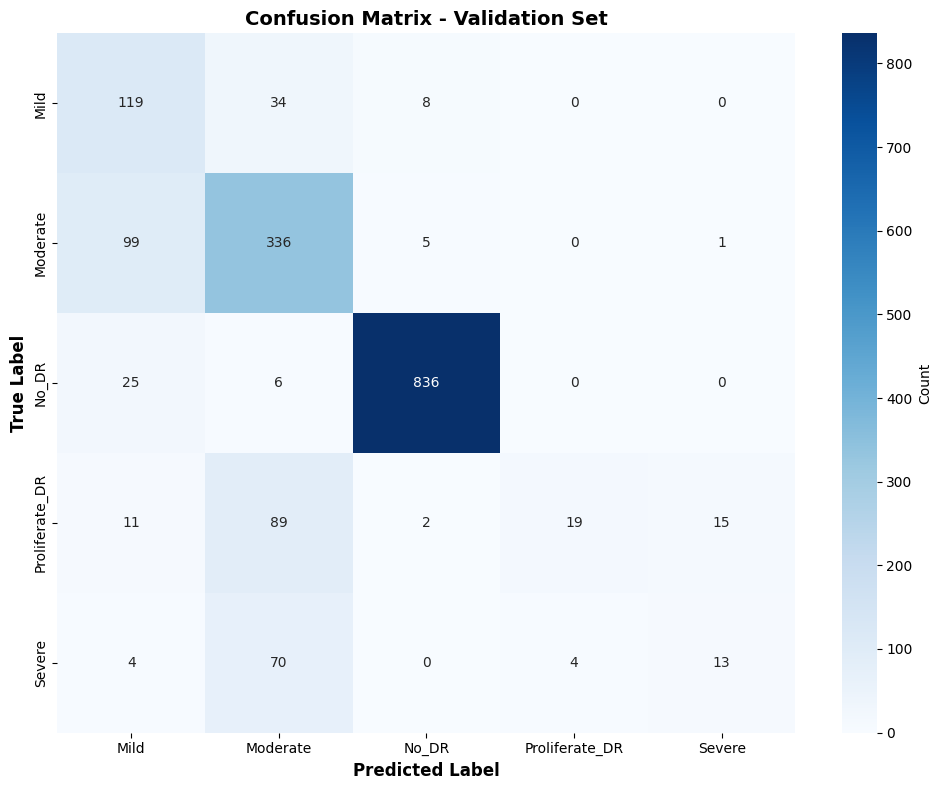

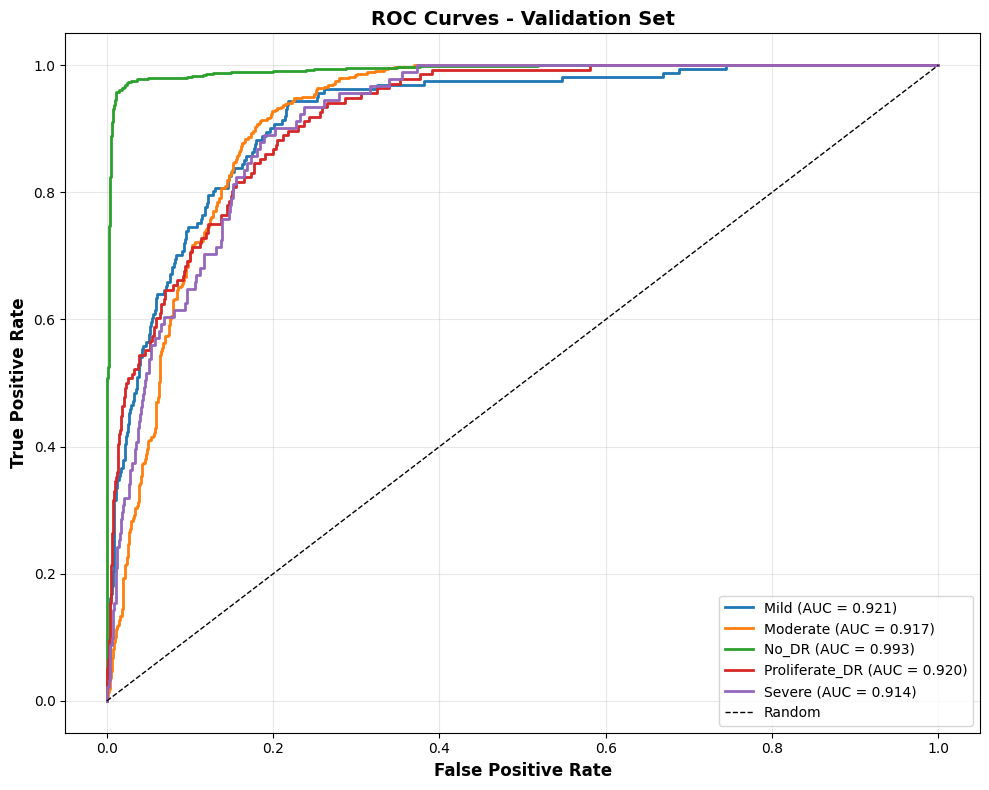


EVALUATING ON TEST SET

Generating predictions...
318/318 [==============================] - 91s 285ms/step

📊 Overall Metrics:
  Loss: 0.0919
  Accuracy: 77.04%
  Balanced Accuracy: 52.73%
  Cohen's Kappa: 0.6438

📋 Classification Report:
                precision    recall  f1-score   support

          Mild     0.4354    0.7137    0.5409       241
      Moderate     0.6158    0.7443    0.6740       661
         No_DR     0.9828    0.9692    0.9760      1300
Proliferate_DR     0.6667    0.1078    0.1857       204
        Severe     0.4000    0.1014    0.1618       138

      accuracy                         0.7704      2544
     macro avg     0.6201    0.5273    0.5077      2544
  weighted avg     0.7786    0.7704    0.7488      2544



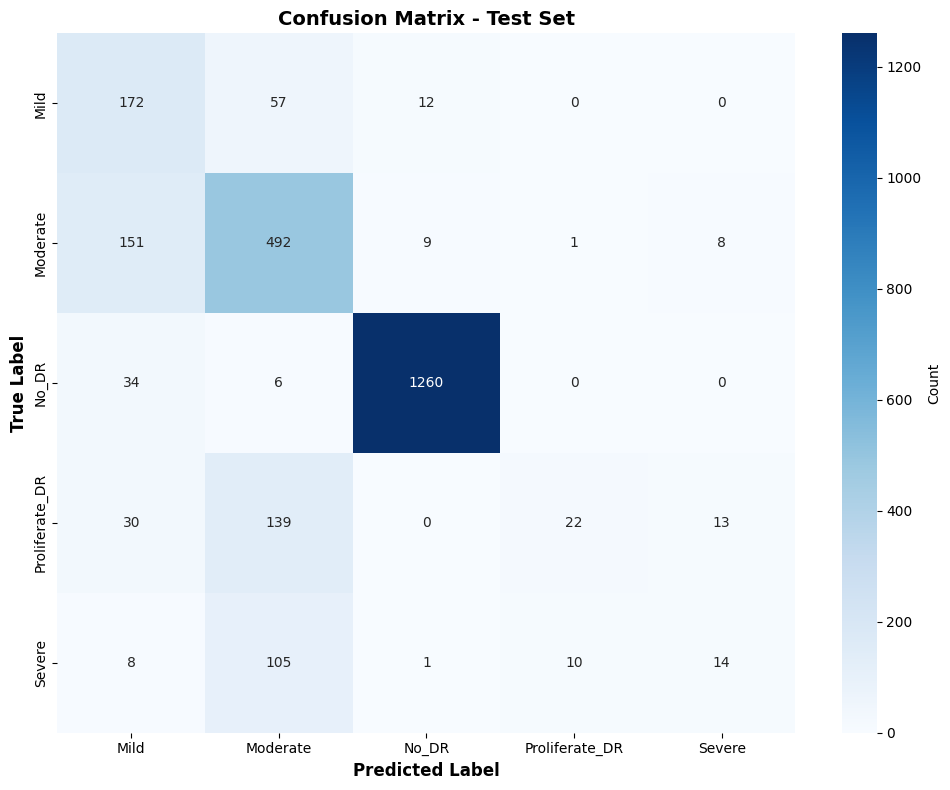

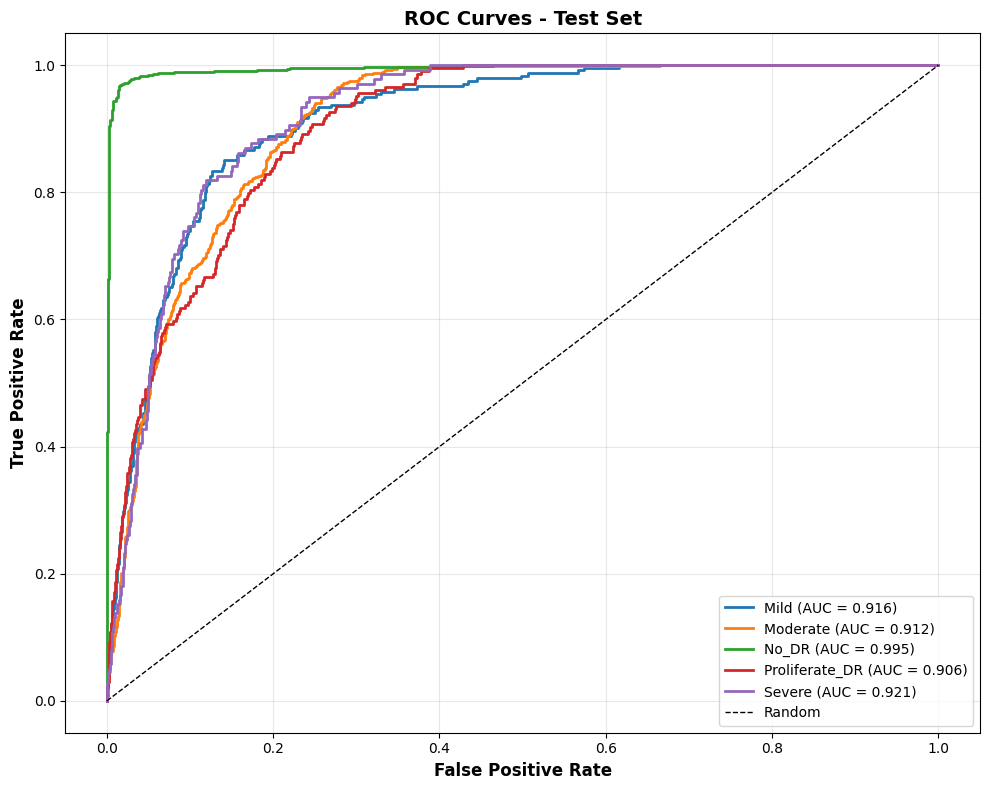

In [19]:
# ============================================================================
# CELL 12: Evaluation Functions
# ============================================================================

def evaluate_model(model, generator, config, split_name='Test'):
    """Comprehensive model evaluation"""
    
    print(f"\n{'='*70}")
    print(f"EVALUATING ON {split_name.upper()} SET")
    print(f"{'='*70}")
    
    # Reset generator
    generator.reset()
    
    # Get predictions
    print("\nGenerating predictions...")
    predictions = model.predict(generator, steps=len(generator), verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Get true labels
    true_classes = generator.classes[:len(predicted_classes)]
    
    # Calculate metrics
    accuracy = np.mean(predicted_classes == true_classes)
    balanced_acc = balanced_accuracy_score(true_classes, predicted_classes)
    kappa = cohen_kappa_score(true_classes, predicted_classes)
    
    # Loss
    loss = model.evaluate(generator, steps=len(generator), verbose=0)
    
    print(f"\n📊 Overall Metrics:")
    print(f"  Loss: {loss[0]:.4f}")
    print(f"  Accuracy: {accuracy*100:.2f}%")
    print(f"  Balanced Accuracy: {balanced_acc*100:.2f}%")
    print(f"  Cohen's Kappa: {kappa:.4f}")
    
    # Get class names
    class_names = list(generator.class_indices.keys())
    
    # Classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(true_classes, predicted_classes,
                               target_names=class_names, digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {split_name} Set', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, f'confusion_matrix_{split_name.lower()}.png'), dpi=300)
    plt.show()
    
    # ROC curves
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        binary_labels = (true_classes == i).astype(int)
        class_probs = predictions[:, i]
        
        fpr, tpr, _ = roc_curve(binary_labels, class_probs)
        auc_score = roc_auc_score(binary_labels, class_probs)
        
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc_score:.3f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title(f'ROC Curves - {split_name} Set', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, f'roc_curves_{split_name.lower()}.png'), dpi=300)
    plt.show()
    
    return {
        'loss': loss[0],
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'kappa': kappa,
        'predictions': predicted_classes,
        'probabilities': predictions,
        'true_labels': true_classes
    }


# Load best model
print("\n📥 Loading best model...")

# Option 1: Load with custom objects (recommended)
try:
    model = keras.models.load_model(
        os.path.join(MODEL_SAVE_PATH, 'best_model.h5'),
        custom_objects={
            'FocalLoss': FocalLoss,
            'BalancedAccuracy': BalancedAccuracy
        },
        compile=True
    )
    print("✓ Model loaded successfully with custom objects")
except Exception as e:
    print(f"⚠️  Error loading with custom objects: {e}")
    print("Trying alternative method...")
    
    # Option 2: Load without compilation and recompile
    try:
        model = keras.models.load_model(
            os.path.join(MODEL_SAVE_PATH, 'best_model.h5'),
            compile=False
        )
        
        # Recompile with original settings
        loss_fn = get_loss_function(CONFIG, class_weights_array)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
            loss=loss_fn if CONFIG['use_focal_loss'] else 'categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
                BalancedAccuracy(num_classes=CONFIG['num_classes'])
            ]
        )
        print("✓ Model loaded and recompiled successfully")
    except Exception as e2:
        print(f"❌ Failed to load model: {e2}")
        print("Using the current model in memory instead")

# Evaluate on validation set
val_results = evaluate_model(model, val_gen, CONFIG, 'Validation')

# Evaluate on test set
test_results = evaluate_model(model, test_gen, CONFIG, 'Test')



PER-CLASS PERFORMANCE ANALYSIS - TEST


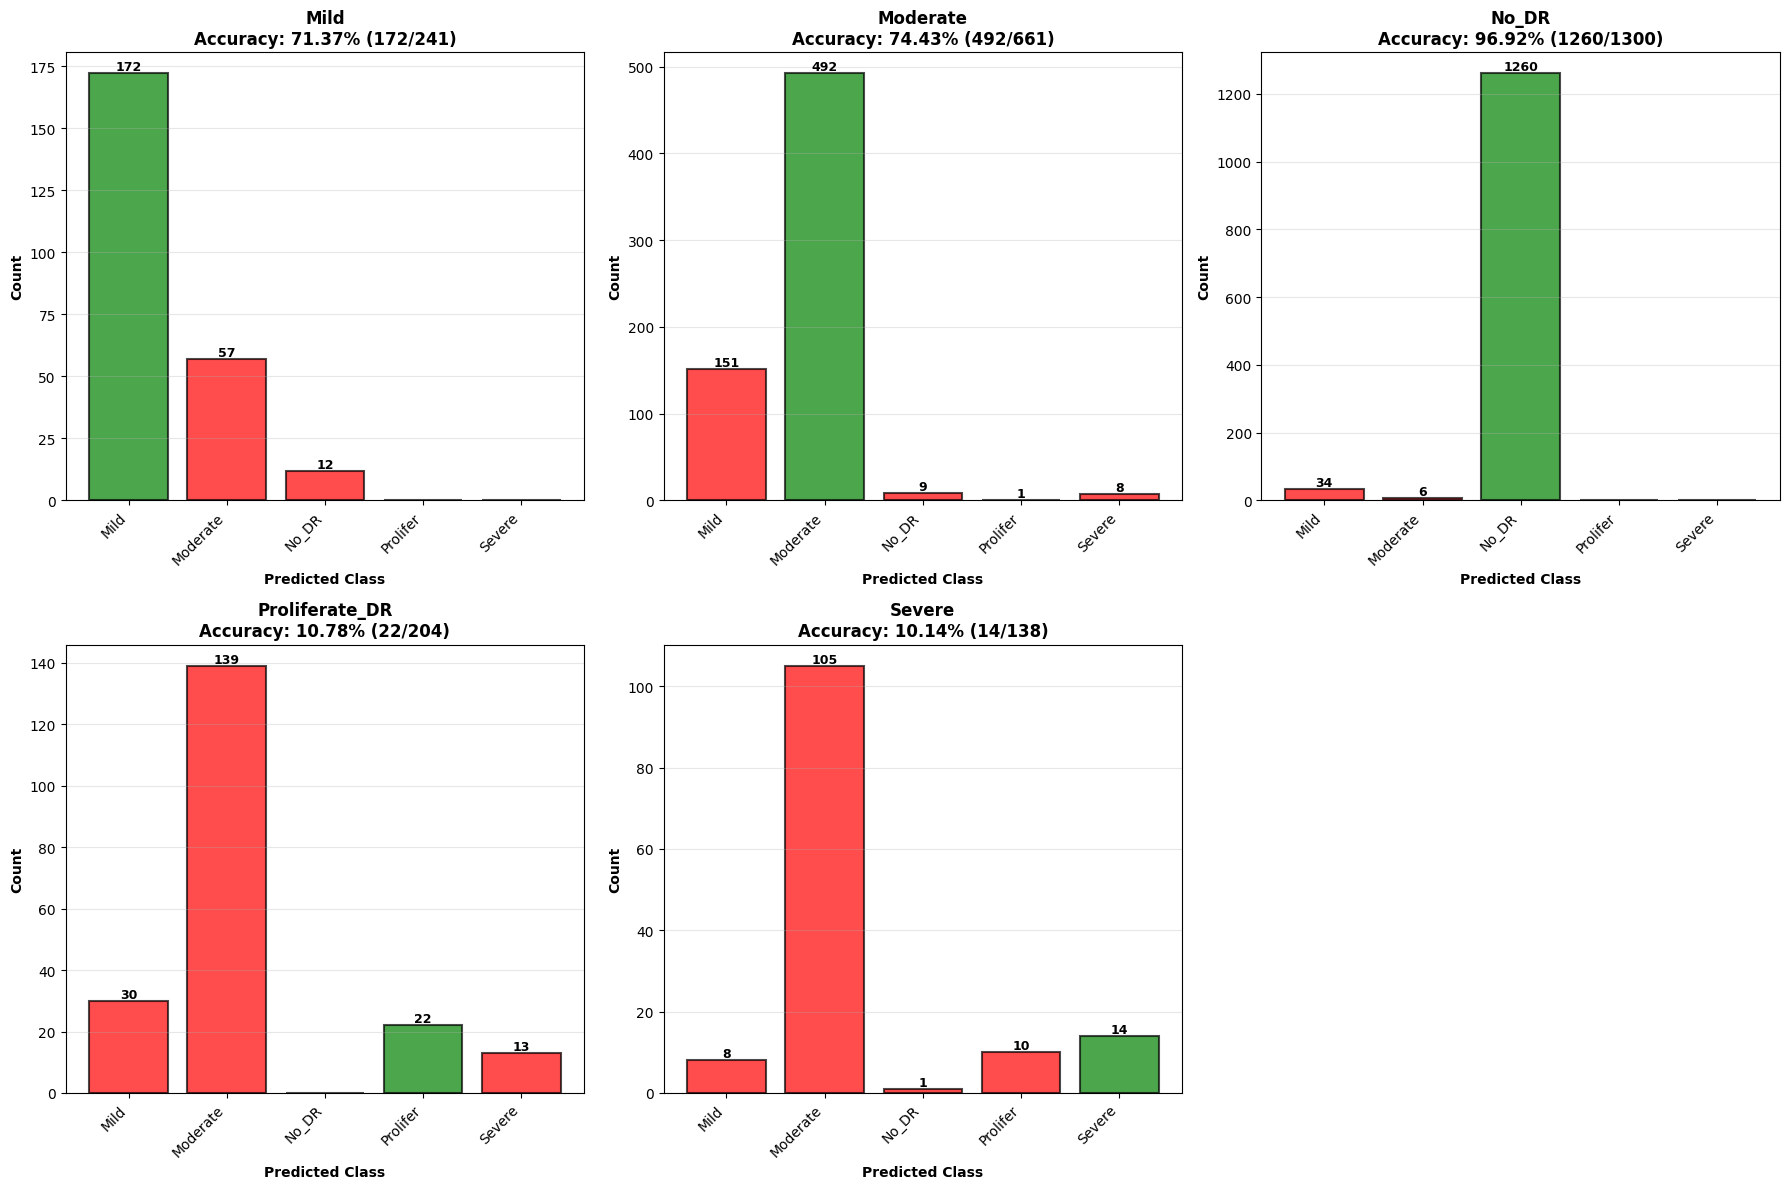

✓ Per-class analysis saved


In [20]:
# ============================================================================
# CELL 13: Per-Class Performance Analysis
# ============================================================================

def analyze_per_class_performance(results, generator, config, split_name='Test'):
    """Detailed per-class performance analysis"""
    
    print(f"\n{'='*70}")
    print(f"PER-CLASS PERFORMANCE ANALYSIS - {split_name.upper()}")
    print(f"{'='*70}")
    
    true_labels = results['true_labels']
    predictions = results['predictions']
    class_names = list(generator.class_indices.keys())
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, class_name in enumerate(class_names):
        ax = axes[i]
        
        # Get indices for this class
        class_indices = true_labels == i
        class_preds = predictions[class_indices]
        
        if len(class_preds) == 0:
            ax.text(0.5, 0.5, f'No samples\nfor {class_name}', 
                   ha='center', va='center', fontsize=12)
            ax.axis('off')
            continue
        
        # Calculate metrics
        correct = np.sum(class_preds == i)
        total = len(class_preds)
        accuracy = correct / total if total > 0 else 0
        
        # Count predictions
        pred_counts = np.bincount(class_preds, minlength=config['num_classes'])
        
        # Create bar chart
        colors = ['green' if j == i else 'red' for j in range(config['num_classes'])]
        bars = ax.bar(range(config['num_classes']), pred_counts, 
                     color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
        
        ax.set_title(f'{class_name}\nAccuracy: {accuracy*100:.2f}% ({correct}/{total})',
                    fontweight='bold', fontsize=12)
        ax.set_xlabel('Predicted Class', fontsize=10, fontweight='bold')
        ax.set_ylabel('Count', fontsize=10, fontweight='bold')
        ax.set_xticks(range(config['num_classes']))
        ax.set_xticklabels([name[:8] for name in class_names], rotation=45, ha='right')
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Hide the 6th subplot if only 5 classes
    if len(class_names) < 6:
        axes[5].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, f'per_class_analysis_{split_name.lower()}.png'), dpi=300)
    plt.show()
    
    print(f"✓ Per-class analysis saved")


# Run per-class analysis
analyze_per_class_performance(test_results, test_gen, CONFIG, 'Test')



VISUALIZING SAMPLE PREDICTIONS


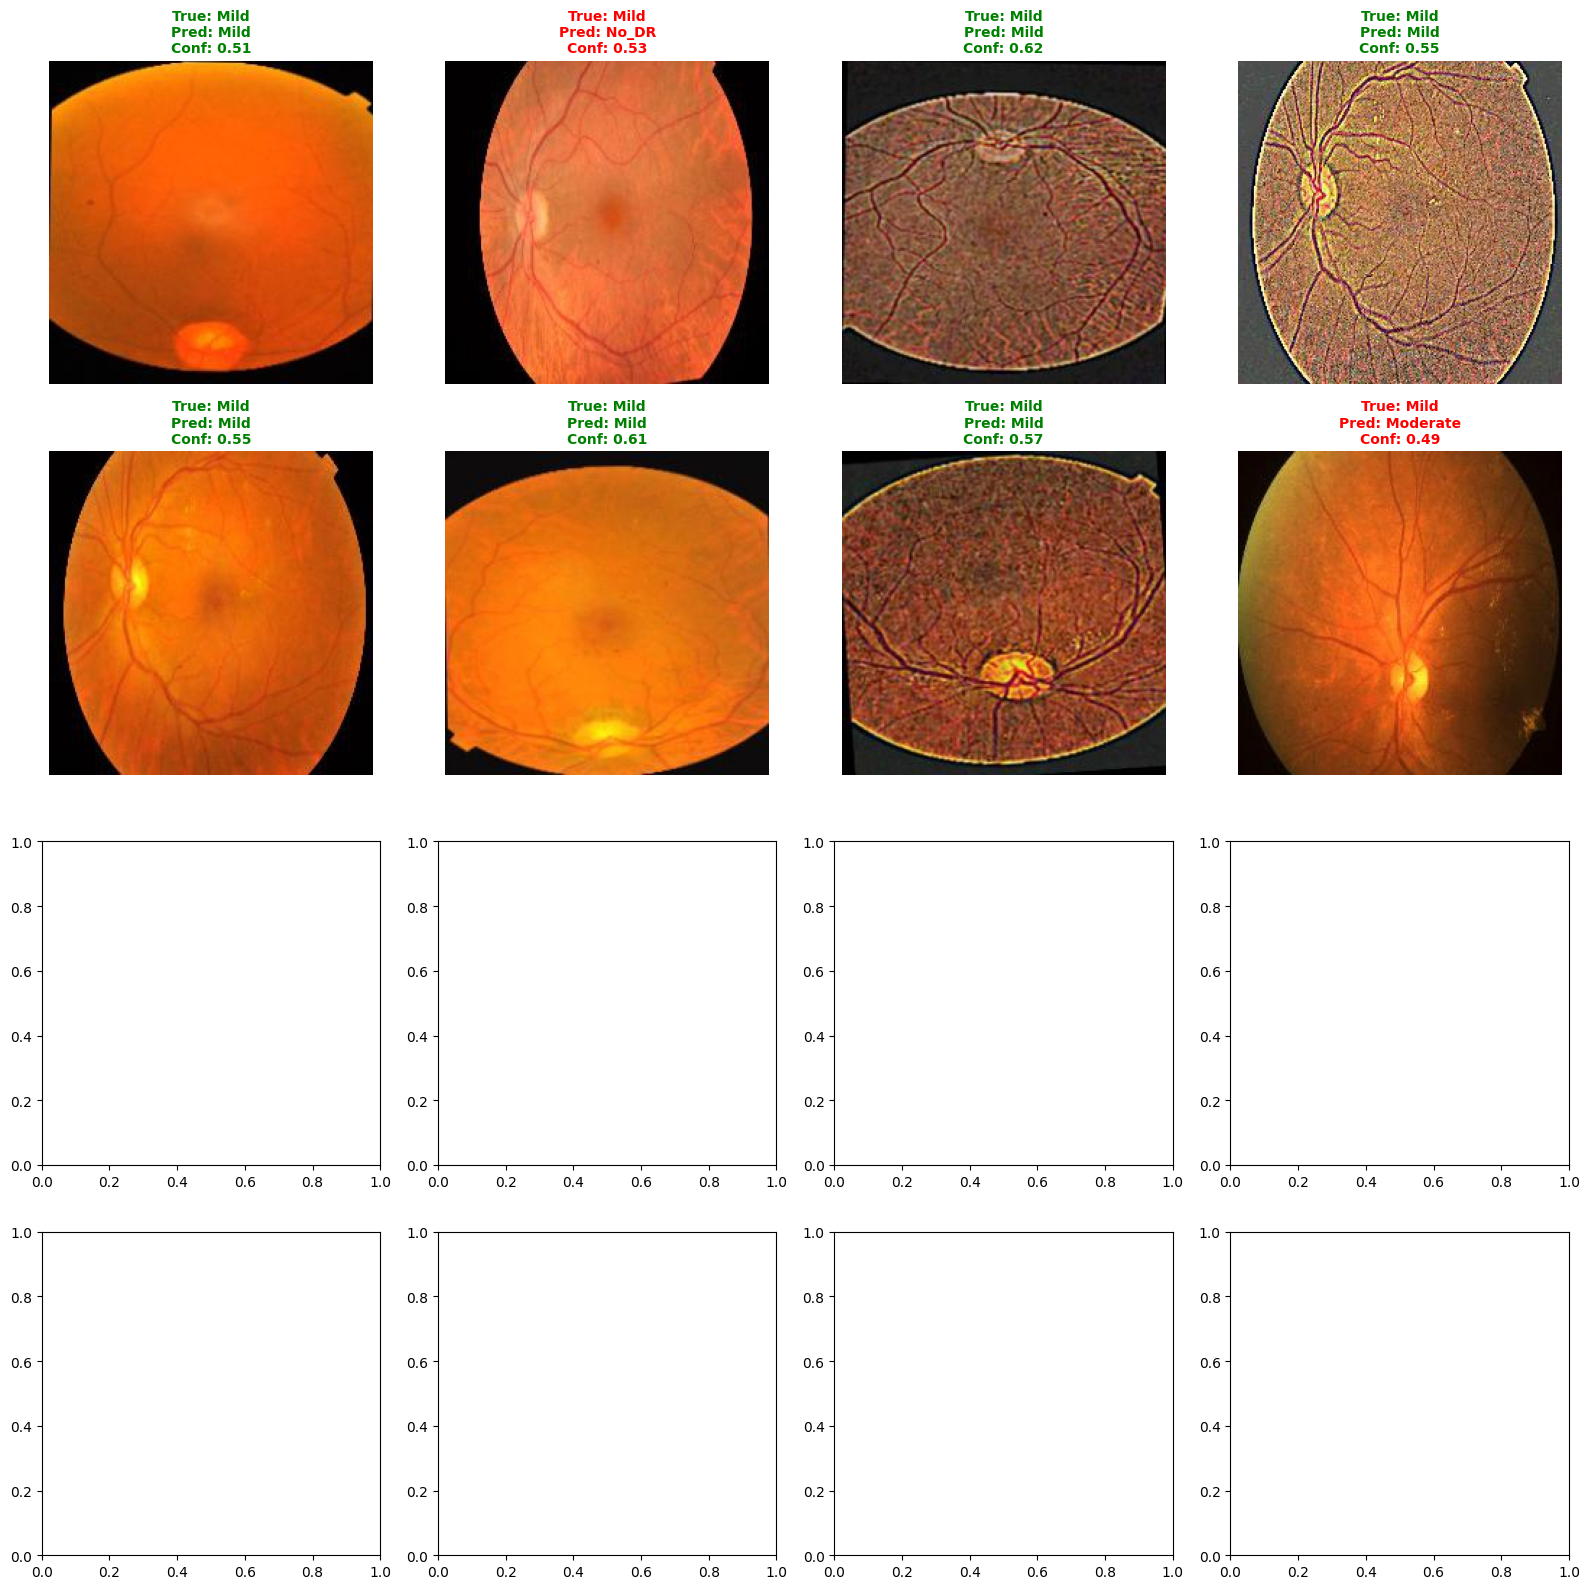

✓ Sample predictions visualization saved


In [21]:
# ============================================================================
# CELL 14: Visualize Sample Predictions
# ============================================================================

def visualize_predictions(model, generator, config, num_samples=16):
    """Visualize sample predictions"""
    
    print(f"\n{'='*70}")
    print("VISUALIZING SAMPLE PREDICTIONS")
    print(f"{'='*70}")
    
    # Get a batch of images
    generator.reset()
    images, labels = next(generator)
    
    # Limit to num_samples
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    # Predict
    predictions = model.predict(images, verbose=0)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    
    # Get class names
    class_names = list(generator.class_indices.keys())
    
    # Plot
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(images))):
        ax = axes[i]
        
        # Display image
        img = images[i]
        ax.imshow(img)
        
        true_label = class_names[true_classes[i]]
        pred_label = class_names[pred_classes[i]]
        confidence = predictions[i][pred_classes[i]]
        
        # Color based on correctness
        color = 'green' if pred_classes[i] == true_classes[i] else 'red'
        
        ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
                    color=color, fontweight='bold', fontsize=10)
        ax.axis('off')
    
    # Hide unused subplots
    for i in range(num_samples, 16):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'sample_predictions.png'), dpi=300)
    plt.show()
    
    print("✓ Sample predictions visualization saved")


# Visualize predictions
visualize_predictions(model, test_gen, CONFIG, num_samples=16)



In [31]:
# ============================================================================
# CELL 15: Generate Final Report
# ============================================================================

def generate_final_report(config, history, val_results, test_results, class_weight_dict):
    """Generate comprehensive final report"""
    
    report = []
    report.append("="*70)
    report.append("ATTENTION U-NET TRAINING - FINAL REPORT (TensorFlow/Keras)")
    report.append("="*70)
    
    report.append("\n📋 MODEL CONFIGURATION:")
    report.append(f"  Architecture: Attention U-Net")
    report.append(f"  Encoder: {config['encoder_name']} (pretrained={config['pretrained_encoder']})")
    report.append(f"  Image Size: {config['img_size']}x{config['img_size']}")
    report.append(f"  Number of Classes: {config['num_classes']}")
    report.append(f"  Batch Size: {config['batch_size']}")
    report.append(f"  Learning Rate: {config['learning_rate']}")
    report.append(f"  Dropout Rate: {config['dropout_rate']}")
    report.append(f"  Loss Function: {'Focal Loss' if config['use_focal_loss'] else 'Categorical Cross Entropy'}")
    report.append(f"  Class Weighting: {'Enabled' if config['use_class_weights'] else 'Disabled'}")
    
    report.append("\n⚖️  CLASS WEIGHTS:")
    for class_idx, weight in class_weight_dict.items():
        report.append(f"  Class {class_idx}: {weight:.4f}")
    
    report.append("\n📊 TRAINING RESULTS:")
    report.append(f"  Total Epochs Trained: {len(history.history['loss'])}")
    report.append(f"  Best Train Loss: {min(history.history['loss']):.4f}")
    report.append(f"  Best Train Accuracy: {max(history.history['accuracy'])*100:.2f}%")
    report.append(f"  Best Val Loss: {min(history.history['val_loss']):.4f}")
    report.append(f"  Best Val Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
    if 'val_balanced_accuracy' in history.history:
        report.append(f"  Best Val Balanced Accuracy: {max(history.history['val_balanced_accuracy'])*100:.2f}%")
    
    report.append("\n🎯 VALIDATION SET PERFORMANCE:")
    report.append(f"  Loss: {val_results['loss']:.4f}")
    report.append(f"  Accuracy: {val_results['accuracy']*100:.2f}%")
    report.append(f"  Balanced Accuracy: {val_results['balanced_accuracy']*100:.2f}%")
    report.append(f"  Cohen's Kappa: {val_results['kappa']:.4f}")
    
    report.append("\n🎯 TEST SET PERFORMANCE:")
    report.append(f"  Loss: {test_results['loss']:.4f}")
    report.append(f"  Accuracy: {test_results['accuracy']*100:.2f}%")
    report.append(f"  Balanced Accuracy: {test_results['balanced_accuracy']*100:.2f}%")
    report.append(f"  Cohen's Kappa: {test_results['kappa']:.4f}")
    
    report.append("\n📁 OUTPUT FILES:")
    report.append(f"  Model: {os.path.join(MODEL_SAVE_PATH, 'best_model.h5')}")
    report.append(f"  Results Directory: {RESULTS_PATH}")
    report.append("    - training_history.png")
    report.append("    - confusion_matrix_validation.png")
    report.append("    - confusion_matrix_test.png")
    report.append("    - roc_curves_validation.png")
    report.append("    - roc_curves_test.png")
    report.append("    - per_class_analysis_test.png")
    report.append("    - sample_predictions.png")
    report.append("    - training_log.csv")
    report.append("    - TensorBoard logs")
    
    report.append("\n💡 RECOMMENDATIONS:")
    
    test_acc = test_results['accuracy']
    bal_acc = test_results['balanced_accuracy']
    kappa = test_results['kappa']
    
    if test_acc < 0.6:
        report.append("  🔴 Model performance is low. Consider:")
        report.append("     - Training for more epochs")
        report.append("     - Using a larger encoder (ResNet50 instead of ResNet34)")
        report.append("     - Increasing data augmentation")
        report.append("     - Collecting more data for minority classes")
    elif test_acc < 0.75:
        report.append("  🟡 Model performance is moderate. Consider:")
        report.append("     - Fine-tuning hyperparameters (learning rate, dropout)")
        report.append("     - Trying focal loss if not already used")
        report.append("     - Ensemble methods")
    else:
        report.append("  ✅ Model performance is good!")
    
    if abs(test_acc - bal_acc) > 0.1:
        report.append("  ⚠️  Large gap between accuracy and balanced accuracy")
        report.append("     - Model struggles with minority classes")
        report.append("     - Consider:")
        report.append("       * Increasing class weights for minority classes")
        report.append("       * Using focal loss")
        report.append("       * More aggressive augmentation for minority classes")
    
    if kappa < 0.4:
        report.append("  ⚠️  Very low Cohen's Kappa score")
        report.append("     - Model predictions have poor agreement with ground truth")
        report.append("     - May need to revisit data quality or model architecture")
    elif kappa < 0.6:
        report.append("  ⚠️  Low Cohen's Kappa score")
        report.append("     - Moderate agreement, room for improvement")
    
    report.append("\n🔧 TENSORBOARD VISUALIZATION:")
    report.append("  To view training logs in TensorBoard, run:")
    report.append(f"  tensorboard --logdir {os.path.join(RESULTS_PATH, 'logs')}")
    
    report.append("\n" + "="*70)
    report.append("REPORT GENERATION COMPLETE")
    report.append("="*70)
    
    # Print report
    report_text = "\n".join(report)
    print(report_text)
    
    # Save report
    with open(os.path.join(RESULTS_PATH, 'final_report.txt'), 'w') as f:
        f.write(report_text)
    
    print(f"\n✓ Final report saved to: {os.path.join(RESULTS_PATH, 'final_report.txt')}")
    
    # Save results to JSON
    import json
    results_dict = {
        'config': config,
        'training_epochs': len(history.history['loss']),
        'best_train_accuracy': float(max(history.history['accuracy'])),
        'best_val_accuracy': float(max(history.history['val_accuracy'])),
        'best_val_balanced_accuracy': float(max(history.history.get('val_balanced_accuracy', [0]))),
        'test_accuracy': float(test_results['accuracy']),
        'test_balanced_accuracy': float(test_results['balanced_accuracy']),
        'test_kappa': float(test_results['kappa']),
        'class_weights': {int(k): float(v) for k, v in class_weight_dict.items()}
    }
    
    with open(os.path.join(RESULTS_PATH, 'results_summary.json'), 'w') as f:
        json.dump(results_dict, f, indent=4)
    
    print(f"✓ Results summary saved to: {os.path.join(RESULTS_PATH, 'results_summary.json')}")


# Generate final report
generate_final_report(CONFIG, history, val_results, test_results, class_weight_dict)



ATTENTION U-NET TRAINING - FINAL REPORT (TensorFlow/Keras)

📋 MODEL CONFIGURATION:
  Architecture: Attention U-Net
  Encoder: resnet50 (pretrained=True)
  Image Size: 224x224
  Number of Classes: 5
  Batch Size: 8
  Learning Rate: 0.0001
  Dropout Rate: 0.5
  Loss Function: Focal Loss
  Class Weighting: Enabled

⚖️  CLASS WEIGHTS:
  Class 0: 4.9307
  Class 1: 1.7998
  Class 2: 0.9150
  Class 3: 0.6073
  Class 4: 0.6658

📊 TRAINING RESULTS:
  Total Epochs Trained: 13
  Best Train Loss: 0.0679
  Best Train Accuracy: 67.45%
  Best Val Loss: 0.0915
  Best Val Accuracy: 78.01%
  Best Val Balanced Accuracy: 62.27%

🎯 VALIDATION SET PERFORMANCE:
  Loss: 0.0915
  Accuracy: 78.01%
  Balanced Accuracy: 54.96%
  Cohen's Kappa: 0.6590

🎯 TEST SET PERFORMANCE:
  Loss: 0.0919
  Accuracy: 77.04%
  Balanced Accuracy: 52.73%
  Cohen's Kappa: 0.6438

📁 OUTPUT FILES:
  Model: C:\Users\anush\Desktop\New folder\Models13\best_model.h5
  Results Directory: C:\Users\anush\Desktop\New folder\Results
    - trai

In [34]:
# ============================================================================
# CELL 18: Final Summary
# ============================================================================

print("\n" + "="*70)
print("🎉 ALL TASKS COMPLETED SUCCESSFULLY! 🎉")
print("="*70)

print("\n📊 Training Summary:")
print(f"  ✓ Model: Attention U-Net with {CONFIG['encoder_name']}")
print(f"  ✓ Total parameters: {model.count_params():,}")
print(f"  ✓ Epochs trained: {len(history.history['loss'])}")
print(f"  ✓ Best validation accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"  ✓ Test accuracy: {test_results['accuracy']*100:.2f}%")
print(f"  ✓ Test balanced accuracy: {test_results['balanced_accuracy']*100:.2f}%")
print(f"  ✓ Test Cohen's Kappa: {test_results['kappa']:.4f}")

print(f"\n📁 Output Locations:")
print(f"  Models: {MODEL_SAVE_PATH}")
print(f"  Results: {RESULTS_PATH}")

print("\n🚀 Next Steps:")
print("  1. Review confusion matrices and ROC curves")
print("  2. Check per-class performance for minority classes")
print("  3. View TensorBoard logs for detailed training analysis")
print("  4. Use predict_single_image() for inference on new images")
print("  5. Deploy model using exported formats")

print("\n💡 Tips:")
print("  - If minority class performance is poor, try focal loss or increase class weights")
print("  - Use TensorBoard for detailed training visualization")
print("  - Consider ensemble methods for better performance")
print("  - Fine-tune on specific classes if needed")

print("\n" + "="*70)
print("Training pipeline completed! Model ready for deployment or further tuning.")
print("="*70)


🎉 ALL TASKS COMPLETED SUCCESSFULLY! 🎉

📊 Training Summary:
  ✓ Model: Attention U-Net with resnet50
  ✓ Total parameters: 74,799,776
  ✓ Epochs trained: 13
  ✓ Best validation accuracy: 78.01%
  ✓ Test accuracy: 77.04%
  ✓ Test balanced accuracy: 52.73%
  ✓ Test Cohen's Kappa: 0.6438

📁 Output Locations:
  Models: C:\Users\anush\Desktop\New folder\Models13
  Results: C:\Users\anush\Desktop\New folder\Results

🚀 Next Steps:
  1. Review confusion matrices and ROC curves
  2. Check per-class performance for minority classes
  3. View TensorBoard logs for detailed training analysis
  4. Use predict_single_image() for inference on new images
  5. Deploy model using exported formats

💡 Tips:
  - If minority class performance is poor, try focal loss or increase class weights
  - Use TensorBoard for detailed training visualization
  - Consider ensemble methods for better performance
  - Fine-tune on specific classes if needed

Training pipeline completed! Model ready for deployment or further